In [1]:
!pip install opencv-python
!pip install opencv-python-headless

     |████████████████████████████████| 60.9 MB 242 kB/s  eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 48.3 MB 12.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
from keras.applications.vgg16 import VGG16 as vgg16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from math import floor
import numpy as np
import cv2
from os import listdir
from os.path import isfile, join
from numpy import expand_dims, array, exp, max
import json
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.densenet import DenseNet121 as densenet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as mobilenetv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,Flatten
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy
from scipy import ndimage
import imageio
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import random

In [3]:
# set the model hyper parameters
BATCH_SIZE = 8
# set the image size to fit the resnet model for lower overfitting
IMG_SIZE = (224, 224)

In [4]:
#@train_df = pd.read_csv("files/test_correlation_above_glcm.csv")
#train_df2 = pd.read_csv("files/test_correlation_below_glcm.csv")

train_df = pd.read_csv("files/mobilenetv2/melanoma/lbp_results/melanoma_lbp_above.csv")
train_df2 = pd.read_csv("files/mobilenetv2/melanoma/lbp_results/melanoma_lbp_below.csv")

In [5]:
print(train_df)

                           file      label
0       benign/ISIC_0010232.jpg     benign
1       benign/ISIC_0011143.jpg     benign
2       benign/ISIC_0000480.jpg     benign
3       benign/ISIC_0010064.jpg     benign
4       benign/ISIC_0010497.jpg     benign
..                          ...        ...
880  malignant/ISIC_0000549.jpg  malignant
881  malignant/ISIC_0000029.jpg  malignant
882  malignant/ISIC_0011387.jpg  malignant
883  malignant/ISIC_0000163.jpg  malignant
884  malignant/ISIC_0000161.jpg  malignant

[885 rows x 2 columns]


In [6]:
train_dataset_gen = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [7]:
training_dataset = train_dataset_gen.flow_from_dataframe(dataframe=train_df,
                                                         directory="isbi2016",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset2 = train_dataset_gen.flow_from_dataframe(dataframe=train_df2,
                                                         directory="isbi2016",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 708 non-validated image filenames belonging to 2 classes.
Found 316 non-validated image filenames belonging to 2 classes.


In [8]:
model_name = densenet
input_t =(224, 224, 3)
#model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top = False, input_shape = input_t)

model_t = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

29089792/29084464 [==============================] - 0s 0us/step


In [9]:
model_t.trainable = False
model_t2.trainable = False

In [10]:
#finetune by removeing the last layer
#for layer in model_t.layers[:-2]:
    #layer.trainable = False

In [11]:
#model classifier topup
#reg=0.001

model = Sequential()
model.add(model_t)
model.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation='softmax'))


model2 = Sequential()
model2.add(model_t2)
model2.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(2, activation='softmax'))

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history = model.fit(training_dataset, batch_size=4, shuffle=True, epochs=100, verbose=1)

model2.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history2 = model2.fit(training_dataset2, batch_size=4, shuffle=True, epochs=100, verbose=1)

Epoch 1/100
89/89 [==============================] - 58s 559ms/step - loss: 1.0720 - accuracy: 0.5503 - precision: 0.5503 - recall: 0.5503
Epoch 2/100
89/89 [==============================] - 30s 340ms/step - loss: 0.9593 - accuracy: 0.5547 - precision: 0.5547 - recall: 0.5547
Epoch 3/100
89/89 [==============================] - 30s 337ms/step - loss: 0.8159 - accuracy: 0.6265 - precision: 0.6265 - recall: 0.6265
Epoch 4/100
89/89 [==============================] - 30s 337ms/step - loss: 0.6689 - accuracy: 0.6988 - precision: 0.6988 - recall: 0.6988
Epoch 5/100
89/89 [==============================] - 30s 337ms/step - loss: 0.6952 - accuracy: 0.6666 - precision: 0.6666 - recall: 0.6666
Epoch 6/100
89/89 [==============================] - 30s 335ms/step - loss: 0.6644 - accuracy: 0.6802 - precision: 0.6802 - recall: 0.6802
Epoch 7/100
89/89 [==============================] - 30s 333ms/step - loss: 0.6985 - accuracy: 0.6490 - precision: 0.6490 - recall: 0.6490
Epoch 8/100
89/89 [========

89/89 [==============================] - 30s 335ms/step - loss: 0.3873 - accuracy: 0.8280 - precision: 0.8280 - recall: 0.8280
Epoch 60/100
89/89 [==============================] - 30s 334ms/step - loss: 0.3948 - accuracy: 0.8077 - precision: 0.8077 - recall: 0.8077
Epoch 61/100
89/89 [==============================] - 30s 336ms/step - loss: 0.4094 - accuracy: 0.8074 - precision: 0.8074 - recall: 0.8074
Epoch 62/100
89/89 [==============================] - 30s 334ms/step - loss: 0.4383 - accuracy: 0.8012 - precision: 0.8012 - recall: 0.8012
Epoch 63/100
89/89 [==============================] - 30s 335ms/step - loss: 0.3717 - accuracy: 0.8398 - precision: 0.8398 - recall: 0.8398
Epoch 64/100
89/89 [==============================] - 30s 332ms/step - loss: 0.3505 - accuracy: 0.8447 - precision: 0.8447 - recall: 0.8447
Epoch 65/100
89/89 [==============================] - 30s 335ms/step - loss: 0.3821 - accuracy: 0.8120 - precision: 0.8120 - recall: 0.8120
Epoch 66/100
89/89 [=============

40/40 [==============================] - 23s 575ms/step - loss: 0.6047 - accuracy: 0.7428 - precision: 0.7428 - recall: 0.7428
Epoch 18/100
40/40 [==============================] - 23s 578ms/step - loss: 0.5490 - accuracy: 0.7219 - precision: 0.7219 - recall: 0.7219
Epoch 19/100
40/40 [==============================] - 23s 585ms/step - loss: 0.5643 - accuracy: 0.7183 - precision: 0.7183 - recall: 0.7183
Epoch 20/100
40/40 [==============================] - 23s 567ms/step - loss: 0.4158 - accuracy: 0.8282 - precision: 0.8282 - recall: 0.8282
Epoch 21/100
40/40 [==============================] - 23s 561ms/step - loss: 0.4169 - accuracy: 0.7972 - precision: 0.7972 - recall: 0.7972
Epoch 22/100
40/40 [==============================] - 23s 585ms/step - loss: 0.4374 - accuracy: 0.8096 - precision: 0.8096 - recall: 0.8096
Epoch 23/100
40/40 [==============================] - 23s 573ms/step - loss: 0.4629 - accuracy: 0.8154 - precision: 0.8154 - recall: 0.8154
Epoch 24/100
40/40 [=============

40/40 [==============================] - 23s 585ms/step - loss: 0.2697 - accuracy: 0.9247 - precision: 0.9247 - recall: 0.9247
Epoch 78/100
40/40 [==============================] - 23s 573ms/step - loss: 0.2448 - accuracy: 0.9304 - precision: 0.9304 - recall: 0.9304
Epoch 79/100
40/40 [==============================] - 23s 569ms/step - loss: 0.3105 - accuracy: 0.8549 - precision: 0.8549 - recall: 0.8549
Epoch 80/100
40/40 [==============================] - 23s 586ms/step - loss: 0.2640 - accuracy: 0.8816 - precision: 0.8816 - recall: 0.8816
Epoch 81/100
40/40 [==============================] - 23s 578ms/step - loss: 0.3313 - accuracy: 0.8684 - precision: 0.8684 - recall: 0.8684
Epoch 82/100
12/40 [========>.....................] - ETA: 16s - loss: 0.2909 - accuracy: 0.8996 - precision: 0.8996 - recall: 0.8996

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


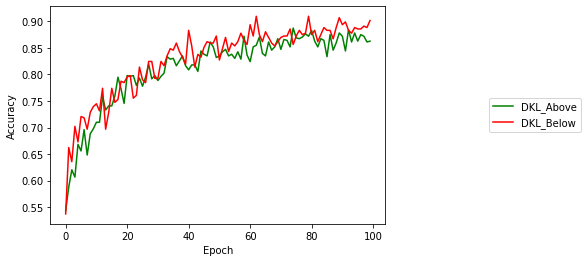

In [31]:
fig1 = plt.figure()



plt.plot(history2.history['accuracy'], color='g')
plt.plot(history.history['accuracy'], color='r')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
#fig1.savefig('densenet121_lbp_DKL_accuracy_melanoma.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


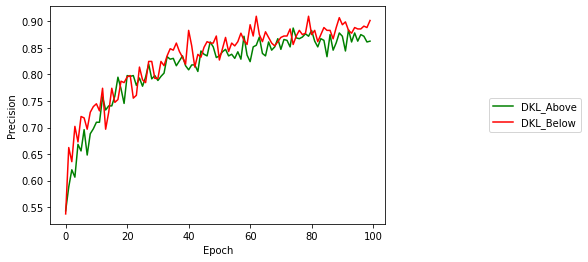

In [18]:
fig1 = plt.figure()


plt.plot(history2.history['precision'], color='g')
plt.plot(history.history['precision'], color='r')

plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
#fig1.savefig('densenet121_lbp_DKL_precision_melanoma.eps',  dpi=1000, format="eps", bbox_inches="tight") 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


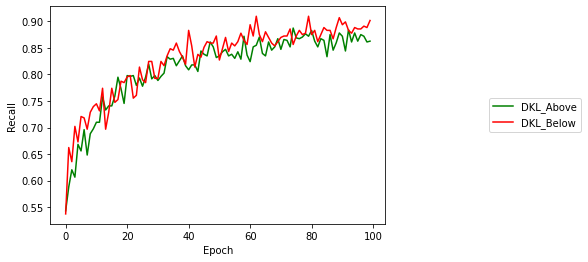

In [20]:
fig1 = plt.figure()

plt.plot(history2.history['recall'], color='g')
plt.plot(history.history['recall'], color='r')

plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
#fig1.savefig('densenet121_lbp_DKL_recall_melanoma.eps',  dpi=1000, format="eps", bbox_inches="tight") 


In [21]:
##for the other correlation
train_df3 = pd.read_csv("files/mobilenetv2/melanoma/glcm_results/melanoma_correlation_above_glcm_above.csv")
train_df4 = pd.read_csv("files/mobilenetv2/melanoma/glcm_results/melanoma_correlation_above_glcm_below.csv")

In [22]:
train_dataset_gen2 = ImageDataGenerator(rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.15, 
        brightness_range=[0.7, 1.4],
        vertical_flip=True,  
        horizontal_flip=True,
        rotation_range=15, 
        
        
        width_shift_range=0.1, 
        height_shift_range=0.1,
        validation_split=0.2,
        fill_mode='nearest')

In [23]:
training_dataset3 = train_dataset_gen2.flow_from_dataframe(dataframe=train_df3,
                                                         directory="isbi2016",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

training_dataset4 = train_dataset_gen2.flow_from_dataframe(dataframe=train_df4,
                                                         directory="isbi2016",
                                                         shuffle=True,
                                                         x_col="file",
                                                         y_col="label",
                                                         batch_size=BATCH_SIZE,
                                                         target_size=IMG_SIZE,
                                                         validate_filenames=False,
                                                         class_mode="categorical",
                                                         subset="training")

Found 656 non-validated image filenames belonging to 2 classes.
Found 368 non-validated image filenames belonging to 2 classes.


In [24]:
model_t3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

model_t4 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape = input_t)

In [25]:
model_t3.trainable = False
model_t4.trainable = False

In [26]:
#model classifier topup
#reg=0.001

model3 = Sequential()
model3.add(model_t3)
model3.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Dropout(0.5))

model3.add(layers.Dense(2, activation='softmax'))


model4 = Sequential()
model4.add(model_t4)
model4.add(Flatten())
#model.add(layers.BatchNormalization())
#model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.L2(reg)))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.5))

model4.add(layers.Dense(2, activation='softmax'))

In [27]:
model3.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history3 = model3.fit(training_dataset3, batch_size=4, shuffle=True, epochs=100, verbose=1)

model4.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy','Precision','Recall'])
history4 = model4.fit(training_dataset4, batch_size=4, shuffle=True, epochs=100, verbose=1)

Epoch 1/100
82/82 [==============================] - 36s 396ms/step - loss: 0.9759 - accuracy: 0.5397 - precision: 0.5397 - recall: 0.5397
Epoch 2/100
82/82 [==============================] - 33s 398ms/step - loss: 0.7768 - accuracy: 0.6045 - precision: 0.6045 - recall: 0.6045
Epoch 3/100
82/82 [==============================] - 32s 393ms/step - loss: 0.7092 - accuracy: 0.6268 - precision: 0.6268 - recall: 0.6268
Epoch 4/100
82/82 [==============================] - 32s 393ms/step - loss: 0.6783 - accuracy: 0.6880 - precision: 0.6880 - recall: 0.6880
Epoch 5/100
82/82 [==============================] - 33s 398ms/step - loss: 0.6851 - accuracy: 0.6757 - precision: 0.6757 - recall: 0.6757
Epoch 6/100
82/82 [==============================] - 32s 396ms/step - loss: 0.6783 - accuracy: 0.6640 - precision: 0.6640 - recall: 0.6640
Epoch 7/100
82/82 [==============================] - 33s 398ms/step - loss: 0.5745 - accuracy: 0.6931 - precision: 0.6931 - recall: 0.6931
Epoch 8/100
82/82 [========

46/46 [==============================] - 19s 418ms/step - loss: 0.5140 - accuracy: 0.7329 - precision: 0.7329 - recall: 0.7329
Epoch 18/100
46/46 [==============================] - 19s 420ms/step - loss: 0.4613 - accuracy: 0.7975 - precision: 0.7975 - recall: 0.7975
Epoch 19/100
46/46 [==============================] - 19s 415ms/step - loss: 0.4670 - accuracy: 0.7624 - precision: 0.7624 - recall: 0.7624
Epoch 20/100
46/46 [==============================] - 19s 414ms/step - loss: 0.4627 - accuracy: 0.7526 - precision: 0.7526 - recall: 0.7526
Epoch 21/100
46/46 [==============================] - 19s 417ms/step - loss: 0.4250 - accuracy: 0.7961 - precision: 0.7961 - recall: 0.7961
Epoch 22/100
46/46 [==============================] - 19s 419ms/step - loss: 0.5454 - accuracy: 0.7466 - precision: 0.7466 - recall: 0.7466
Epoch 23/100
46/46 [==============================] - 19s 414ms/step - loss: 0.4143 - accuracy: 0.7904 - precision: 0.7904 - recall: 0.7904
Epoch 24/100
46/46 [=============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


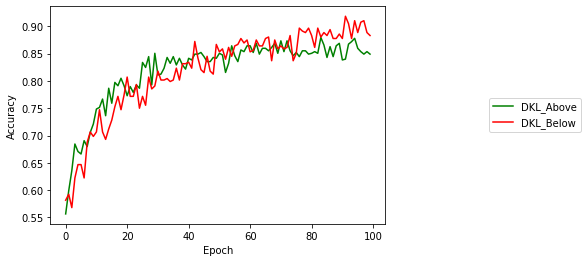

In [32]:
fig2 = plt.figure()



plt.plot(history3.history['accuracy'], color='g')
plt.plot(history4.history['accuracy'], color='r')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig2.savefig('mobilenetv2_glcm_correlation_DKL_accuracy_melanoma.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


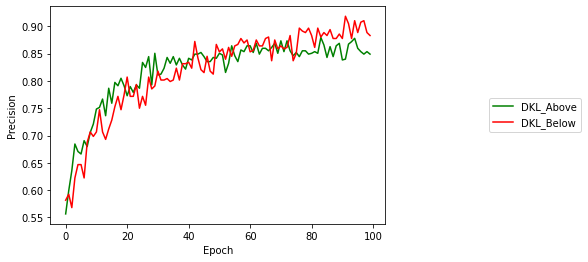

In [33]:
fig2 = plt.figure()


plt.plot(history3.history['precision'], color='g')
plt.plot(history4.history['precision'], color='r')

plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig2.savefig('mobilenetv2_glcm_correlation_DKL_precision_melanoma.eps',  dpi=1000, format="eps", bbox_inches="tight") 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


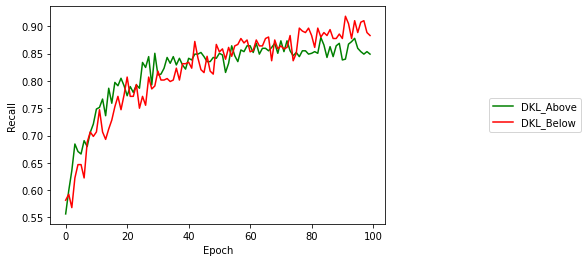

In [34]:
fig2 = plt.figure()

plt.plot(history3.history['recall'], color='g')
plt.plot(history4.history['recall'], color='r')

plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['DKL_Above','DKL_Below'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig2.savefig('mobilenetv2_glcm_correlation_DKL_recall_melanoma.eps',  dpi=1000, format="eps", bbox_inches="tight") 